# STEP3 TA IndéMode  入力

>### 環境構築

ターミナルにて  
 ● pip install streamlit  
 ● pip install requests  
 ● pip install pandas  
 ● pip install beautifulsoup4  

>### コードまとめ

IndéMode
サロン開業を検討したい方に向けた物件検索・マーケティング分析アプリです。

Q1. 物件検索する都内の路線を選択してください。
Q2. 物件検索する都内の駅を選択してください。

まずは「 JR山手線有楽町駅 」の周辺情報を調査します。

■ 有楽町駅 の情報
 ・東京都内駅利用者数ランキング: 18 位
 ・利用者数: 512,493 人/日

■ 有楽町駅所在エリア の情報
 ・エリア: 千代田区
 ・エリア賃料相場: 26956 円/坪
 ・エリア内サロン件数 from 楽天Beauty: 26 件
 ・エリア内カット単価平均額: 4952.5 円


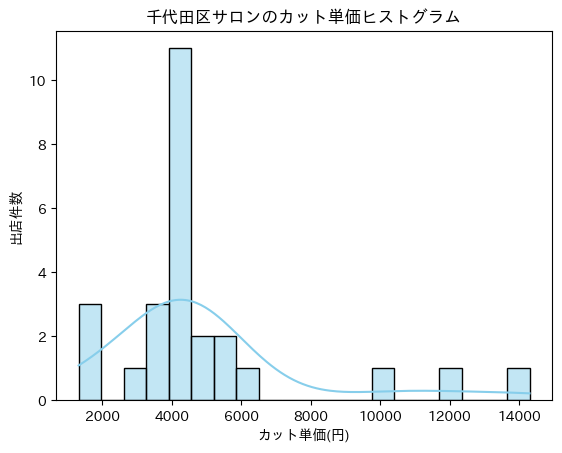

In [16]:
# ライブラリインポート
import streamlit as st
import sqlite3
import requests
import pandas as pd
from time import sleep
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt #グラフ描画ライブラリ
import japanize_matplotlib # matplotlib日本語化対応ライブラリ
import seaborn as sns

# DB読み込み
# SQLite接続
conn = sqlite3.connect('STEP3チーム課題_TA_IndéMode_DB.db') 
# SQLクエリを実行してデータフレームに読み込む
query1 = 'SELECT * FROM "首都圏の乗降客数ランキング";'  
query2 = 'SELECT * FROM "東京23区賃料(募集金額)相場目安ランキングfrom飲食店ドットコム";'  
query3 = 'SELECT * FROM "東京23区スクレイピングコード一覧";'  
query4 = 'SELECT * FROM "東京23区路線一覧";' 
query5 = 'SELECT * FROM "東京23区駅一覧_JR,東京メトロ";'  
df1 = pd.read_sql_query(query1, conn)
df2 = pd.read_sql_query(query2, conn)
df3 = pd.read_sql_query(query3, conn)
df4 = pd.read_sql_query(query4, conn)
df5 = pd.read_sql_query(query5, conn)
conn.close()  # データベース接続を閉じる

# リスト作成
line_list = df4['路線名']
station_list = df5['駅名']

# アプリタイトル
print('IndéMode')
print('サロン開業を検討したい方に向けた物件検索・マーケティング分析アプリです。')
print('')

# 入力 
print('Q1. 物件検索する都内の路線を選択してください。')
print('Q2. 物件検索する都内の駅を選択してください。')
#line = st.selectbox("路線名を選択して下さい。", line_list)
#station = st.selectbox("駅を選択して下さい。", station_list)
line = "JR山手線"
station = '有楽町'
print('')
print('まずは「 ' + line + station + '駅 」の周辺情報を調査します。')
print('')


# 駅情報取得
#display(df1.head(10))

# heartrails.express APIで緯度経度、郵便番号を取得
url = "https://express.heartrails.com/api/json?method=getStations&line=" + line + "&name=" + station
response = requests.get(url)

# エリア調査関数
def get_area_info(line, station):
    res = response.json()
    station_data = res.get('response', {}).get('station', [])
    if station_data:
        # 最初の駅情報を取得
        first_station = station_data[0]
        station_longitude = first_station.get('x')
        station_latitude = first_station.get('y')
        station_postal = first_station.get('postal')

        # 郵便番号検索 APIで緯度経度を元に住所を取得
        postal_url = "https://zipcloud.ibsnet.co.jp/api/search?zipcode=" + station_postal
        postal_response = requests.get(postal_url)
        postal_res = postal_response.json()
        station_area = postal_res['results'][0].get('address2')   
        
        # 駅所在エリアの賃料相場を取得
        #display(df2.head(10))
        area_average_rent = str(df2[df2["区名"] == station_area][["平均額(円/坪)"]].values[0][0])
        
        # 駅所在エリアのサロン情報を取得
        # display(df3.head(10))
        area_code =str(df3[df3["区名"] == station_area].values[0][1])
        # 情報格納のための空配列を用意
        s_name = []
        s_access = []
        s_price = []
        # HTML取得
        URL = 'https://beauty.rakuten.co.jp/addr' + area_code + '/page{}/'
        # 複数ページ取得のためのループ処理
        for i in range(1,4):
            # 変数trget_urlに、アクセス先のURLを格納する
            saron_url = URL.format(i)
            # サーバー負荷低減のための1s待機
            sleep(1)
            #print()してtrget_url確認
            #print(saron_url)
            # リクエスト
            saron_res = requests.get(saron_url)
            # リクエスト結果を確認
            #saron_result = saron_res.text
            #print(saron_result)
            # 文字コード変換 (→ utf-8 )
            saron_res.encoding = 'utf-8'
            # 文字化けしていないかhtmlを確認
            #print(saron_res.text)
            # BeautifulSoup(解析したいデータ,解析する方法)を指定し、soupに代入
            soup = BeautifulSoup(saron_res.text, "html.parser")
            #print(soup)
            # sectionデータ(1物件分データ)の取得
            property_section = soup.select('div.m-shopCard__headerContent')
            # 取得したセクションすべての数を確認します。
            #print(len(property_section))
            # property_sectionからsectionを1つずつ取り出してpsに代入。
            for ps in property_section:
                ps1 = ps.select('h3.m-shopCard__shopName')[0].text
                ps2 = ps.select('li.m-shopCard__headerOutlineItem')[0].text.replace("アクセス：","")
                ps3 = ps.select('li.m-shopCard__headerOutlineItem')[1].text.replace("カット単価：","").replace("～","").replace("￥","")
                # それぞれ抽出したデータを配列に追加
                s_name.append(ps1)
                s_access.append(ps2)
                s_price.append(ps3)
            # 物件数確認
            #print('サロン件数', len(s_name))
        # データ定義
        data_list = {
            "サロン名" : s_name,
            "アクセス" : s_access,
            "カット単価(円~)" : s_price,
        }
        # データフレーム作成
        df6 = pd.DataFrame(data_list)
        # 重複データ処理
        df6.drop_duplicates(inplace=True)
        df6.reset_index(drop=True,inplace=True)
        #display(df6)
        # SQLでDBにデータ保存
        # SQLiteデータベースへの接続
        db_path = "STEP3チーム課題_TA_IndéMode_DB.db"
        conn = sqlite3.connect(db_path) 
        # データフレームをSQLiteデータベースに書き込む
        table_name = '近隣サロン一覧_楽天beauty'  # テーブル名を適切なものに変更してください
        df6.to_sql(table_name, conn, if_exists='replace', index=False)
        #print(db_path + ' への書き込みが完了しました')
        # DBからデータを読み取り、近隣サロンの価格帯を表示
        # SQLiteデータベース接続
        conn = sqlite3.connect('STEP3チーム課題_TA_IndéMode_DB.db')
        # SQLクエリを実行してデータフレームに読み込む
        query7 = 'SELECT * FROM "近隣サロン一覧_楽天beauty";'  
        df7 = pd.read_sql_query(query7, conn)
        # データベース接続を閉じる
        conn.close()
        # display(df7)
        df7['カット単価(円~)'] = df7['カット単価(円~)'].str.replace(',', '').astype(float) #データ数値化
        df7 = df7.sort_values(by='カット単価(円~)') #データ整列
        # display(df5)

        return {
            '緯度': station_latitude,
            '経度': station_longitude,
            '郵便番号': station_postal,
            '利用者数ランク': df1[df1["駅名"] == station][["ランキング"]].values[0],
            '利用者数': df1[df1["駅名"] == station][["利用者数(人/日)"]].values[0],
            'エリア': station_area,
            'エリア賃料相場': area_average_rent,
            'エリア内サロン件数 from 楽天Beauty': len(df7),
            'エリア内カット単価': df7['カット単価(円~)'],   
            'エリア内カット単価平均額': df7['カット単価(円~)'].mean(),   
        }
    
    else:
        print("該当する駅情報が見つかりませんでした。")
        return None       

if response.status_code == 200:
    result = get_area_info(line, station)
    if result is not None:
        # リクエストが成功した場合の処理
        print('■ ' + station + '駅 の情報')
        print(' ・東京都内駅利用者数ランキング:', result['利用者数ランク'][0], '位')
        print(' ・利用者数:', result['利用者数'][0], '人/日')
        print('')
        print('■ ' + station + '駅所在エリア の情報')
        print(' ・エリア:', result['エリア'])
        print(' ・エリア賃料相場:', result['エリア賃料相場'], '円/坪')
        print(' ・エリア内サロン件数 from 楽天Beauty:', result['エリア内サロン件数 from 楽天Beauty'], '件')
        print(' ・エリア内カット単価平均額:',  result['エリア内カット単価平均額'], '円')
        sns.histplot(result['エリア内カット単価'], bins=20, kde=True, color='skyblue')  # kde=Trueでカーネル密度推定も表示
        plt.xlabel('値')
        plt.xlabel('カット単価(円)')
        plt.ylabel('出店件数')
        plt.title('千代田区サロンのカット単価ヒストグラム')
        plt.show()
else:
    # リクエストがエラーの場合の処理
    print("路線名、駅名を再確認して下さい。")

>### コード

In [113]:
# ライブラリインポート
import streamlit as st
import sqlite3
import requests
import pandas as pd
from time import sleep
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt #グラフ描画ライブラリ
import japanize_matplotlib # matplotlib日本語化対応ライブラリ
import seaborn as sns

In [33]:
#アプリタイトル
print('IndéMode')
print('サロン開業を検討したい方に向けた物件検索・マーケティング分析アプリです。')

IndéMode
サロン開業を検討したい方に向けた物件検索・マーケティング分析アプリです。


In [67]:
#検索条件
line_list = [ "JR中央線",
            "JR中央本線",
            "JR五日市線",
            "JR京浜東北線",
            "JR京葉線",
            "JR八高線",
            "JR南武線",
            "JR埼京線",
            "JR宇都宮線",
            "JR山手線",
            "JR常磐線各駅停車",
            "JR常磐線快速",
            "JR東海道本線",
            "JR横浜線",
            "JR横須賀線",
            "JR武蔵野線",
            "JR湘南新宿ライン",
            "JR総武線",
            "JR総武線快速",
            "JR青梅線",
            "JR高崎線",
            "つくばエクスプレス線",
            "上越新幹線",
            "上野モノレール",
            "京成押上線",
            "京成本線",
            "京成金町線",
            "京成成田空港線",
            "京浜急行本線",
            "京浜急行空港線",
            "京王線",
            "京王新線",
            "京王井の頭線",
            "京王相模原線",
            "京王高尾線",
            "京王動物園線",
            "京王競馬場線",
            "北総鉄道",
            "埼玉高速鉄道",
            "多摩モノレール",
            "小田急多摩線",
            "小田急小田原線",
            "御岳登山鉄道",
            "新交通ゆりかもめ",
            "東京りんかい線",
            "東京メトロ丸ノ内分岐線",
            "東京メトロ丸ノ内線",
            "東京メトロ千代田線",
            "東京メトロ半蔵門線",
            "東京メトロ南北線",
            "東京メトロ日比谷線",
            "東京メトロ有楽町線",
            "東京メトロ東西線",
            "東京メトロ銀座線",
            "東京メトロ副都心線",
            "東京モノレール羽田線",
            "東北新幹線",
            "東急世田谷線",
            "東急多摩川線",
            "東急大井町線",
            "東急東横線",
            "東急池上線",
            "東急田園都市線",
            "東急目黒線",
            "東武亀戸線",
            "東武伊勢崎線",
            "東武大師線",
            "東武東上本線",
            "東海道新幹線",
            "西武国分寺線",
            "西武多摩川線",
            "西武多摩湖線",
            "西武山口線",
            "西武拝島線",
            "西武新宿線",
            "西武有楽町線",
            "西武池袋線",
            "西武西武園線",
            "西武豊島線",
            "都営三田線",
            "都営大江戸線",
            "都営新宿線",
            "都営浅草線",
            "都電荒川線",
            "北陸新幹線",
            "高尾登山電鉄線",
            "日暮里・舎人ライナー",
            "JR上野東京ライン",
            "相鉄・JR直通線"]

station_list = ["新宿", "渋谷", "有楽町", "東京"]

print('物件検索する都内の路線名を選択してください。')
print('物件検索する都内の駅を選択してください。')

#line = st.selectbox("路線名を選択して下さい。", line_list)
#station = st.selectbox("駅を選択して下さい。", station_list)
line = "JR山手線"
station = '有楽町'

print('まずは' + line + station + '駅の周辺情報を調査します。')

物件検索する都内の路線名を選択してください。
物件検索する都内の駅を選択してください。
まずはJR山手線有楽町駅の周辺情報を調査します。


In [32]:
#駅情報取得(利用者数ランキング)

# SQLiteデータベース接続
conn = sqlite3.connect('STEP3チーム課題_TA_IndéMode_DB.db')
# SQLクエリを実行してデータフレームに読み込む
query1 = 'SELECT * FROM "首都圏の乗降客数ランキング";'  
df1 = pd.read_sql_query(query1, conn)
# データベース接続を閉じる
conn.close()

#display(df1.head(10))

print('■ ' + station + '駅の利用者数')
print('  ・都内駅利用者数ランキング：' + str(df1[df1["駅名"] == station][["ランキング"]].values[0]).replace('[','').replace(']','') + '位')
print('  ・利用者数：' + str(df1[df1["駅名"] == station][["利用者数(人/日)"]].values[0]).replace("['","").replace("']","") + '人/日')

■ 有楽町駅の利用者数
  ・都内駅利用者数ランキング：18位
  ・利用者数：512,493人/日


In [83]:
#駅情報取得(住所・緯度経度)

# APIにリクエストするURL
url = "https://express.heartrails.com/api/json?method=getStations&line=" + line + "&name=" + station
response = requests.get(url)
res = response.json()
station_longitude = res['response']['station'][0].get('x')
station_latitude = res['response']['station'][0].get('y')
station_postal = res['response']['station'][0].get('postal')

postal_url = "https://zipcloud.ibsnet.co.jp/api/search?zipcode=" + station_postal
postal_response = requests.get(postal_url)
postal_res = postal_response.json()
station_area = postal_res['results'][0].get('address2')

#print('■ ' + station + '駅の所在エリア')
#print(" ・エリア：" + str(station_area))
#print(" ・経度：" + str(station_longitude))
#print(" ・経度：" + str(station_latitude))


■ 有楽町駅の所在地
 ・エリア：千代田区
 ・経度：139.763806
 ・経度：35.675441


In [100]:
#駅所在エリアの賃料相場

# SQLiteデータベース接続
conn = sqlite3.connect('STEP3チーム課題_TA_IndéMode_DB.db')
# SQLクエリを実行してデータフレームに読み込む
query2 = 'SELECT * FROM "東京23区賃料(募集金額)相場目安ランキングfrom飲食店ドットコム";'  
df2 = pd.read_sql_query(query2, conn)
# データベース接続を閉じる
conn.close()

#display(df2.head(10))

area_average_rent = str(df2[df2["区名"] == station_area][["平均額(円/坪)"]].values[0][0])

print('■ ' + station + '駅所在エリア情報')
print(" ・エリア：" + str(station_area))
print(" ・所在エリアの賃料相場：" + area_average_rent + "円/坪")

■ 有楽町駅所在エリア情報
 ・エリア：千代田区
 ・所在エリア賃料相場：26956円/坪


In [115]:
#駅所在エリアのサロン情報

# SQLiteデータベース接続
conn = sqlite3.connect('STEP3チーム課題_TA_IndéMode_DB.db')
# SQLクエリを実行してデータフレームに読み込む
query3 = 'SELECT * FROM "東京23区スクレイピングコード一覧";'  
df3 = pd.read_sql_query(query3, conn)
# データベース接続を閉じる
conn.close()
#display(df3.head(10))
area_code =str(df3[df3["区名"] == station_area].values[0][1])

# 情報格納のための空配列を用意
s_name = []
s_access = []
s_price = []

# HTML取得
URL = 'https://beauty.rakuten.co.jp/addr' + area_code + '/page{}/'

# 複数ページ取得のためのループ処理
for i in range(1,4):

    # 変数trget_urlに、アクセス先のURLを格納する
    saron_url = URL.format(i)

    #サーバー負荷低減のための1s待機
    sleep(1)

    #print()してtrget_url確認
    print(saron_url)

    # リクエスト
    saron_res = requests.get(saron_url)

    # リクエスト結果を確認
    #saron_result = saron_res.text
    #print(saron_result)

    # 文字コード変換 (→ utf-8 )
    saron_res.encoding = 'utf-8'

    # 文字化けしていないかhtmlを確認
    #print(saron_res.text)

    # BeautifulSoup(解析したいデータ,解析する方法)を指定し、soupに代入
    soup = BeautifulSoup(saron_res.text, "html.parser")
    #print(soup)

    # sectionデータ(1物件分データ)の取得
    property_section = soup.select('div.m-shopCard__headerContent')

    # 取得したセクションすべての数を確認します。
    print(len(property_section))

    # property_sectionからsectionを1つずつ取り出してpsに代入。
    for ps in property_section:
        ps1 = ps.select('h3.m-shopCard__shopName')[0].text
        ps2 = ps.select('li.m-shopCard__headerOutlineItem')[0].text.replace("アクセス：","")
        ps3 = ps.select('li.m-shopCard__headerOutlineItem')[1].text.replace("カット単価：","").replace("～","").replace("￥","")

        # それぞれ抽出したデータを配列に追加
        s_name.append(ps1)
        s_access.append(ps2)
        s_price.append(ps3)
        
    # 物件数確認
    #print('サロン件数', len(s_name))

# データ定義
data_list = {
    "サロン名" : s_name,
    "アクセス" : s_access,
    "カット単価(円~)" : s_price,
}

# データフレーム作成
df4 = pd.DataFrame(data_list)

# 重複データ処理
df4.drop_duplicates(inplace=True)
df4.reset_index(drop=True,inplace=True)
#display(df4)

# SQLでDBにデータ保存
# SQLiteデータベースへの接続
db_path = "STEP3チーム課題_TA_IndéMode_DB.db"
conn = sqlite3.connect(db_path) 

# データフレームをSQLiteデータベースに書き込む
table_name = '近隣サロン一覧_楽天beauty'  # テーブル名を適切なものに変更してください
df4.to_sql(table_name, conn, if_exists='replace', index=False)

print(db_path + ' への書き込みが完了しました')

https://beauty.rakuten.co.jp/addr13101/page1/
26
https://beauty.rakuten.co.jp/addr13101/page2/
0
https://beauty.rakuten.co.jp/addr13101/page3/
0
STEP3チーム課題_TA_IndéMode_DB.db への書き込みが完了しました


■ 有楽町駅所在エリア情報
 ・エリア：千代田区
 ・エリア内サロン件数 from 楽天Beauty：26件
 ・エリア内サロンカット単価 平均価格：4952.5円


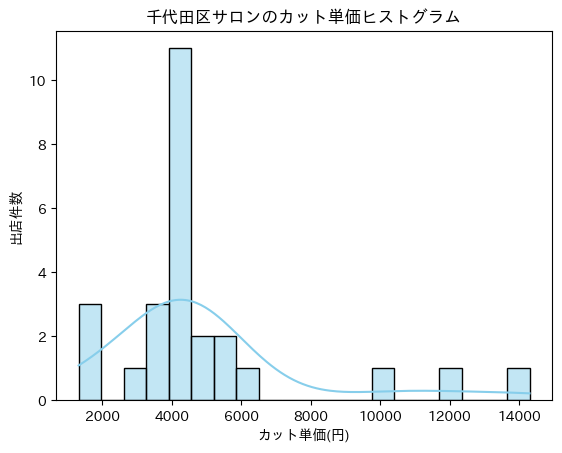

In [121]:
#駅所在エリアのサロン情報2

# DBからデータを読み取り、近隣サロンの価格帯を表示
# SQLiteデータベース接続
conn = sqlite3.connect('STEP3チーム課題_TA_IndéMode_DB.db')
# SQLクエリを実行してデータフレームに読み込む
query5 = 'SELECT * FROM "近隣サロン一覧_楽天beauty";'  
df5 = pd.read_sql_query(query5, conn)
# データベース接続を閉じる
conn.close()

# display(df5)

df5['カット単価(円~)'] = df5['カット単価(円~)'].str.replace(',', '').astype(float) #データ数値化
df5 = df5.sort_values(by='カット単価(円~)') #データ整列

# display(df5)

print('■ ' + station + '駅所在エリア情報')
print(" ・エリア：" + str(station_area))
print(" ・エリア内サロン件数 from 楽天Beauty：" + str(len(df5)) + "件")
print(" ・エリア内サロンカット単価 平均価格：" + str(df5['カット単価(円~)'].mean()) + "円")

sns.histplot(df5['カット単価(円~)'], bins=20, kde=True, color='skyblue')  # kde=Trueでカーネル密度推定も表示
plt.xlabel('値')
plt.xlabel('カット単価(円)')
plt.ylabel('出店件数')
plt.title('千代田区サロンのカット単価ヒストグラム')
plt.show()